# Data Analysis: Call Distribution Across Datasets

> Analyze the distribution of cell types across different datasets by processing all files in the `data/data-processed-nodes-with-harmonized-cell-types` directory.

In [1]:
import numpy as np
import pandas as pd
import os
import json
import requests
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")   

In [2]:
basepath = "/u/yashjain/hra-cell-distance-analysis/data"
data_filedir = "data-processed-nodes-with-harmonized-cell-types"
figures_output_dir = "generated-figures"

In [3]:
# Function to load your data
def load_data(path):
    data = pd.read_csv(path)
    return data

In [4]:
# Function to read all files ending with "-nodes.csv" in the `data_filedir` directory into a single DataFrame. 
# An additional column `Tissue Type` is added to identify the dataset each row belongs to which comes from the subdirectory name in `data_filedir` that the file belongs to. 
# Another additional column `Dataset` is added to identify the dataset name which comes from the filename befrore the `-nodes.csv` suffix.
def read_all_datasets(basepath, data_filedir):
    all_files = []
    for subdir, dirs, files in os.walk(os.path.join(basepath, data_filedir)):
        for file in files:
            if file.endswith("-nodes.csv"):
                file_path = os.path.join(subdir, file)
                tissue_type = os.path.basename(subdir)
                dataset_name = file.replace("-nodes.csv", "")
                df = load_data(file_path)
                df['Tissue Type'] = tissue_type
                df['Dataset'] = dataset_name
                all_files.append(df)
    return pd.concat(all_files, ignore_index=True)

In [5]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

In [6]:
print(len(os.listdir(os.path.join(basepath, data_filedir))))

14


In [7]:
# Create destination directory. Overwrite if it exists.
if os.path.exists(os.path.join(basepath, figures_output_dir)):
    shutil.rmtree(os.path.join(basepath, figures_output_dir))
    print(f"Directory '{figures_output_dir}' already exists and has been removed. New directory will be created.")
else:
    print(f"Directory '{figures_output_dir}' does not exist and will be created.")
os.makedirs(os.path.join(basepath, figures_output_dir), exist_ok=False)

Directory 'generated-figures' already exists and has been removed. New directory will be created.


## Per Dataset Cell Summary

In [8]:
# Call the function to read all datasets
df_all_data = read_all_datasets(basepath, data_filedir)

In [9]:
# Print the first few rows of the DataFrame
df_all_data.head(5)

x           y Original Cell Type Level Three Cell Type  \
0  1503.64128  1278.32154                 NK   natural killer cell   
1  1958.05496  1553.46072                 NK   natural killer cell   
2  2290.93940  1187.36332                 NK   natural killer cell   
3  2863.48554   891.08862                 NK   natural killer cell   
4  2563.43664  1468.54122                 NK   natural killer cell   

  Level Three CL Label Level Three CL ID       CL_Match/3  \
0  natural killer cell        CL:0000623  skos:exactMatch   
1  natural killer cell        CL:0000623  skos:exactMatch   
2  natural killer cell        CL:0000623  skos:exactMatch   
3  natural killer cell        CL:0000623  skos:exactMatch   
4  natural killer cell        CL:0000623  skos:exactMatch   

   Level Two Cell Type   Level Two CL Label Level Two CL ID       CL_Match/2  \
0  natural killer cell  natural killer cell      CL:0000623  skos:exactMatch   
1  natural killer cell  natural killer cell      CL:0000623  skos:exactMatch   
2  natural killer cell  natural killer cell      CL:0000623  skos:exactMatch   
3  natural killer cell  natural killer cell      CL:0000623  skos:exactMatch   
4  natural killer cell  natural killer cell      CL:0000623  skos:exactMatch   

  Level One Cell Type Level One CL Label Level One CL ID       CL_Match/1  \
0         immune cell          leukocyte      CL:0000738  skos:exactMatch   
1         immune cell          leukocyte      CL:0000738  skos:exactMatch   
2         immune cell          leukocyte      CL:0000738  skos:exactMatch   
3         immune cell          leukocyte      CL:0000738  skos:exactMatch   
4         immune cell          leukocyte      CL:0000738  skos:exactMatch   

                Tissue Type         Dataset   z  
0  intestine-codex-stanford  B004_Ascending NaN  
1  intestine-codex-stanford  B004_Ascending NaN  
2  intestine-codex-stanford  B004_Ascending NaN  
3  intestine-codex-stanford  B004_Ascending NaN  
4  intestine-codex-stanford  B004_Ascending NaN

In [69]:
# Print the total number of unique datasets per each tissue type
print("Total number of unique datasets per each tissue type:")
print(df_all_data.groupby('Tissue Type')['Dataset'].nunique())

# Print the sum of number of unique datasets overall.
print("\nTotal number of unique datasets overall:")
print(df_all_data['Dataset'].nunique())

Total number of unique datasets per each tissue type:
Tissue Type
bonemarrow-codex-chop                       20
colon-cycif-sorgerlab                       25
colon-xenium-stanford                       29
esophagus-codex-stanford                     1
intestine-codex-stanford                    64
lung-codex-urmc                              2
lymphnode-codex-yale                         5
maternalfetalinterface-mibitof-stanford    209
oralcavity-codex-czi                        13
pancreas-geomx-ufl                          12
skin-celldive-ge                            10
skin-confocal-sorgerlab                      2
spleen-codex-ufl                             6
tonsil-codex-stanford                        1
Name: Dataset, dtype: int64

Total number of unique datasets overall:
399


In [70]:
# Print the total number of cells per tissue type
print("Total number of cells per tissue type:")
tissue_counts = df_all_data.groupby('Tissue Type')['Original Cell Type'].count()
for tissue, count in tissue_counts.items():
	print(f"{tissue}: {count:,}")

# Print the sum of number of cells overall. Format the output number to be more readable.
print("\nTotal number of cells overall:")
print(f"{df_all_data['Original Cell Type'].count():,}")

Total number of cells per tissue type:
bonemarrow-codex-chop: 1,214,088
colon-cycif-sorgerlab: 12,758,141
colon-xenium-stanford: 2,639,215
esophagus-codex-stanford: 45,958
intestine-codex-stanford: 2,512,185
lung-codex-urmc: 1,209,309
lymphnode-codex-yale: 8,918,845
maternalfetalinterface-mibitof-stanford: 477,747
oralcavity-codex-czi: 1,412,189
pancreas-geomx-ufl: 14,891,875
skin-celldive-ge: 48,323
skin-confocal-sorgerlab: 55,255
spleen-codex-ufl: 992,398
tonsil-codex-stanford: 173,968

Total number of cells overall:
47,349,496


In [71]:
# Print the total number of unique cell types per tissue type. Compute separately for each cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type).
print("Total number of unique cell types per tissue type:")

# Create a summary table
tissue_types = df_all_data['Tissue Type'].unique()
columns = ['Original Cell Type', 'Level Three Cell Type', 'Level Two Cell Type', 'Level One Cell Type']

# Create a dictionary to store results
results = {}
for tissue in tissue_types:
    tissue_data = df_all_data[df_all_data['Tissue Type'] == tissue]
    results[tissue] = {}
    for col in columns:
        results[tissue][col] = tissue_data[col].nunique()

# Convert to DataFrame for better formatting
summary_df = pd.DataFrame(results).T
summary_df = summary_df[columns]  # Reorder columns

# Add a row for "Overall Unique Cell Types" which contains the total number of unique cell types across all tissue types from df_all_data for each column.
overall_unique = df_all_data[columns].nunique()
summary_df.loc['Total Unique Cell Types'] = overall_unique

summary_df

Total number of unique cell types per tissue type:


Original Cell Type  \
intestine-codex-stanford                                 25   
tonsil-codex-stanford                                    10   
esophagus-codex-stanford                                 12   
colon-cycif-sorgerlab                                    21   
colon-xenium-stanford                                    41   
lymphnode-codex-yale                                     34   
maternalfetalinterface-mibitof-stanford                  26   
oralcavity-codex-czi                                     39   
pancreas-geomx-ufl                                        4   
skin-celldive-ge                                          8   
skin-confocal-sorgerlab                                  15   
spleen-codex-ufl                                         12   
lung-codex-urmc                                          54   
bonemarrow-codex-chop                                    37   
Total Unique Cell Types                                 295   

                                         Level Three Cell Type  \
intestine-codex-stanford                                    25   
tonsil-codex-stanford                                       10   
esophagus-codex-stanford                                    12   
colon-cycif-sorgerlab                                       21   
colon-xenium-stanford                                       38   
lymphnode-codex-yale                                        29   
maternalfetalinterface-mibitof-stanford                     23   
oralcavity-codex-czi                                        29   
pancreas-geomx-ufl                                           4   
skin-celldive-ge                                             8   
skin-confocal-sorgerlab                                     15   
spleen-codex-ufl                                            12   
lung-codex-urmc                                             20   
bonemarrow-codex-chop                                       33   
Total Unique Cell Types                                    162   

                                         Level Two Cell Type  \
intestine-codex-stanford                                  17   
tonsil-codex-stanford                                      8   
esophagus-codex-stanford                                  11   
colon-cycif-sorgerlab                                      7   
colon-xenium-stanford                                     20   
lymphnode-codex-yale                                      10   
maternalfetalinterface-mibitof-stanford                   11   
oralcavity-codex-czi                                      20   
pancreas-geomx-ufl                                         4   
skin-celldive-ge                                           4   
skin-confocal-sorgerlab                                   11   
spleen-codex-ufl                                           9   
lung-codex-urmc                                           17   
bonemarrow-codex-chop                                     22   
Total Unique Cell Types                                   57   

                                         Level One Cell Type  
intestine-codex-stanford                                   5  
tonsil-codex-stanford                                      5  
esophagus-codex-stanford                                   5  
colon-cycif-sorgerlab                                      5  
colon-xenium-stanford                                      6  
lymphnode-codex-yale                                       3  
maternalfetalinterface-mibitof-stanford                    5  
oralcavity-codex-czi                                       6  
pancreas-geomx-ufl                                         3  
skin-celldive-ge                                           3  
skin-confocal-sorgerlab                                    4  
spleen-codex-ufl                                           3  
lung-codex-urmc                                            7  
bonemarrow-codex-chop                                      6  
Total

In [72]:
# Extract the following columns from df_all_data: Original Cell Type, Level Three Cell Type, Level Three CL Label, Level Three CL ID, CL_Match/3, Level Two Cell Type, Level Two CL Label, Level Two CL ID, CL_Match/2, Level One Cell Type, Level One CL Label, Level One CL ID, CL_Match/1.
# Create a table containing these columns but have the rows be unique combinations of these columns.

columns = [
    'Original Cell Type',
    'Level Three Cell Type',
    'Level Three CL Label',
    'Level Three CL ID',
    'CL_Match/3',
    'Level Two Cell Type',
    'Level Two CL Label',
    'Level Two CL ID',
    'CL_Match/2',
    'Level One Cell Type',
    'Level One CL Label',
    'Level One CL ID',
    'CL_Match/1',
    'Tissue Type',
]

# Extract the unique combinations of these columns from df_all_data. Sort the DataFrame by 'Level Three Cell Type' in ascending order.
unique_combinations = df_all_data[columns].drop_duplicates().sort_values(by='Level Three Cell Type', ascending=True)

unique_combinations.reset_index(drop=True, inplace=True)

unique_combinations


Original Cell Type  \
0                      Acinar Cells   
1                             Acini   
2                        Adipocytes   
3                         Adipocyte   
4                        Adipocytes   
5                           B Cells   
6                                 B   
7                           B cells   
8                           B cells   
9                            B cell   
10                          B-Cells   
11                         B_cell_1   
12                                B   
13                B cells, red pulp   
14                      B_activated   
15                      Fol B cells   
16                          B_GC_LZ   
17                          B_GC_DZ   
18                       B_GC_prePB   
19                  Immature_B_Cell   
20                            B_IFN   
21                         Memory B   
22                            B_mem   
23                          Naive B   
24                          B_naive   
25                          B_preGC   
26                        B_Cycling   
27                        Beta cell   
28                      CD34+ CD61+   
29               Ki67 proliferating   
30                               DC   
31                  Dendritic cells   
32                               DC   
33                               DC   
34                  Dendritic Cells   
35              CD11B+ CD11C- cells   
36                          DC_cDC1   
37                          DC_cDC2   
38                              FDC   
39                         DC_CCR7+   
40                           DC_pDC   
41                              pDC   
42                        Endosteal   
43                      Endothelial   
44                      Endothelial   
45                      Endothelial   
46                           Endo_p   
47                         ENDO_SMC   
48                      Endothelial   
49                      Endothelial   
50                      Endothelial   
51                      Endothelial   
52                      Endothelial   
53                      Endothelial   
54                      Endothelial   
55                           Endo_2   
56                           ENDO_1   
57                              AEC   
58                         CAP_ENDO   
59                       Podoplanin   
60                        Lymphatic   
61            Lymphatic_Endothelium   
62      Lymphatic endothelial cells   
63      Lymphatic Endothelial Cells   
64            lymphatic Endothelium   
65         Lymphatic Vascular Cells   
66                 Sinusoidal cells   
67                              SEC   
68                blood endothelial   
69                       VEC Progen   
70       Vascular Endothelial Cells   
71                       Enterocyte   
72                      Enterocytes   
73                 CD57+ Enterocyte   
74                 CD66+ Enterocyte   
75             Immature Enterocytes   
76                 MUC1+ Enterocyte   
77           Enterocyte Progenitors   
78                  Enteroendocrine   
79               Best4+ Enterocytes   
80                      Melanocytes   
81                Lung_Epithelial_1   
82                        Ionocytes   
83                       Epithelial   
84                     Merkel Cells   
85                Lung_Epithelial_4   
86                Lung_Epithelial_p   
87          Ductal Epithelial Cells   
88                            Ducts   
89                      Ductal cell   
90           Ki67+ Tumor/Epithelial   
91           PDL1+ Tumor/Epithelial   
92             Secretory_epithelial   
93                     Erythroblast   
94           MEP/Early Erythroblast   
95                        Erythroid   
96                      Fibroblasts   
97                      Fibroblasts   
98    Cancer Associated Fibroblasts   
99              Crypt Fibroblasts 1   
100             Crypt Fibroblasts 2   
101             Crypt Fibroblasts 3   


In [78]:
# Print if there are any duplicates in the Original Cell Type column of the unique combinations DataFrame.
if unique_combinations['Original Cell Type'].duplicated().any():
    print("There are duplicates in the Original Cell Type column of the unique combinations DataFrame. This is expected because same Original Cell Type can be in multiple Tissue Types.")

# Print the duplicate values with their row indices.
duplicates = unique_combinations[unique_combinations['Original Cell Type'].duplicated(keep=False)]
duplicates

There are duplicates in the Original Cell Type column of the unique combinations DataFrame. This is expected because same Original Cell Type can be in multiple Tissue Types.


Original Cell Type          Level Three Cell Type  \
2             Adipocytes                      adipocyte   
4             Adipocytes                      adipocyte   
6                      B                         b cell   
7                B cells                         b cell   
8                B cells                         b cell   
12                     B                         b cell   
30                    DC                 dendritic cell   
32                    DC                 dendritic cell   
33                    DC                 dendritic cell   
43           Endothelial               endothelial cell   
44           Endothelial               endothelial cell   
45           Endothelial               endothelial cell   
48           Endothelial               endothelial cell   
49           Endothelial               endothelial cell   
50           Endothelial               endothelial cell   
51           Endothelial               endothelial cell   
52           Endothelial               endothelial cell   
53           Endothelial               endothelial cell   
54           Endothelial               endothelial cell   
96           Fibroblasts                     fibroblast   
97           Fibroblasts                     fibroblast   
108               Goblet                    goblet cell   
109               Goblet                    goblet cell   
136               Innate           lymphoid cell:innate   
137               Innate           lymphoid cell:innate   
142          Macrophages                     macrophage   
143          Macrophages                     macrophage   
147          Macrophages                     macrophage   
152           Macrophage                     macrophage   
153           Macrophage                     macrophage   
167                 Mast                      mast cell   
168                 Mast                      mast cell   
171                 Mast                      mast cell   
179            Monocytes                       monocyte   
180            Monocytes                       monocyte   
185         SmoothMuscle             muscle cell:smooth   
187                 VSMC             muscle cell:smooth   
189         SmoothMuscle             muscle cell:smooth   
191                 VSMC             muscle cell:smooth   
207                   NK            natural killer cell   
211                   NK            natural killer cell   
217                Nerve                         neuron   
218                Nerve                         neuron   
219                Nerve                         neuron   
225               Paneth                    paneth cell   
226               Paneth                    paneth cell   
228               Plasma                    plasma cell   
229         Plasma Cells                    plasma cell   
230               Plasma                    plasma cell   
231         Plasma Cells                    plasma cell   
232               Plasma                    plasma cell   
233               Plasma                    plasma cell   
242  Squamous_epithelial       squamous epithelial cell   
243  Squamous_epithelial       squamous epithelial cell   
245               Stroma                   stromal cell   
246               Stroma                   stromal cell   
247               Stroma                   stromal cell   
248                 PDPN       stromal cell:podoplanin+   
249                 PDPN       stromal cell:podoplanin+   
250                    T                         t cell   
251                    T                         t cell   
259          CD4+ T cell                   t cell:cd4+    
266          CD4+ T cell         t cell:cd4+ alpha-beta   
293                  NKT  t cell:mature natural killer    
294                  NKT  t cell:mature natural killer    
298                 Treg              t cell:regulatory   
302                 Treg              t cell:regulato

## Heatmap for Cell Type Distribution at Different Levels of Cell Type Annotation Across Datasets 

In [20]:
# Method to create a heatmap visualization of cell type distribution across datasets.
def create_heatmap(df, normalize_method='percent', cell_type_level='Level Three Cell Type'):
    """
    Create an aesthetically enhanced heatmap visualization.
    """
    # Set the style and font
    plt.style.use("seaborn-v0_8-white")
    # plt.rcParams['font.family'] = 'sans-serif'
    # plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Transpose the dataframe and sort index (cell types) alphabetically
    df_plot = df
    df_plot = df_plot.sort_index(axis=1)
    
    # Normalize the data
    if normalize_method == 'percent':
        df_plot = df_plot.div(df_plot.sum(axis=1), axis=0) * 100
    
    # Create binary mask for coloring
    binary_mask = (df_plot > 0).astype(float)
    
    # Calculate figure size
    width = max(16, len(df_plot.columns) * 0.4)
    height = max(8, len(df_plot.index) * 0.4)
    
    # Create figure with higher DPI for better quality
    fig, ax = plt.subplots(figsize=(width, height), dpi=150)
    
    # Define custom colors
    bg_color = '#ffffff'  # Pure white background
    present_color = '#2878B5'  # Professional blue
    absent_color = '#f8f9fa'  # Very light gray
    text_color = '#333333'  # Dark gray for text
    grid_color = '#e6e6e6'  # Light gray for grid
    
    # Set figure background color
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)
    
    # Create custom colormap
    custom_cmap = sns.color_palette([absent_color, present_color], n_colors=2)
    
    # Create heatmap with enhanced styling
    ax = sns.heatmap(binary_mask,
                     cmap=custom_cmap,
                     annot=df_plot,
                     fmt='.1f',
                     cbar=False,
                     linewidths=0.5,
                     linecolor=grid_color,
                     annot_kws={
                         'size': 7,
                         'color': text_color,
                         'ha': 'center',
                         'va': 'center'
                     },
                     square=True)
    
    # Style the axis labels with better positioning
    plt.xticks(rotation=90, color=text_color, ha='center', va='top')
    plt.yticks(rotation=0, color=text_color, va='center')
    
    # Enhance axis labels with adjusted positioning
    ax.set_xlabel(cell_type_level, fontsize=11, fontweight='bold', color=text_color, labelpad=15)
    ax.set_ylabel('Tissue Type', fontsize=11, fontweight='bold', color=text_color, labelpad=10)
    
    # Add title with styling
    plt.title('Cell Type Distribution Across Datasets', 
             pad=20,
             fontsize=13,
             fontweight='bold',
             color=text_color)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Adjust layout with specific margins
    plt.tight_layout(pad=1.5)
    
    # Save figure with high quality
    plt.savefig(f'{os.path.join(basepath, figures_output_dir)}/cell_type_distribution_binary_heatmap_{cell_type_level}.png',
                dpi=300,
                bbox_inches='tight',
                pad_inches=0.5,
                facecolor=bg_color)
    
    # Save fig as svg
    plt.savefig(f'{os.path.join(basepath, figures_output_dir)}/cell_type_distribution_binary_heatmap_{cell_type_level}.svg',
                dpi=600,
                bbox_inches='tight',
                pad_inches=0.5,
                facecolor=bg_color)
    
    return ax



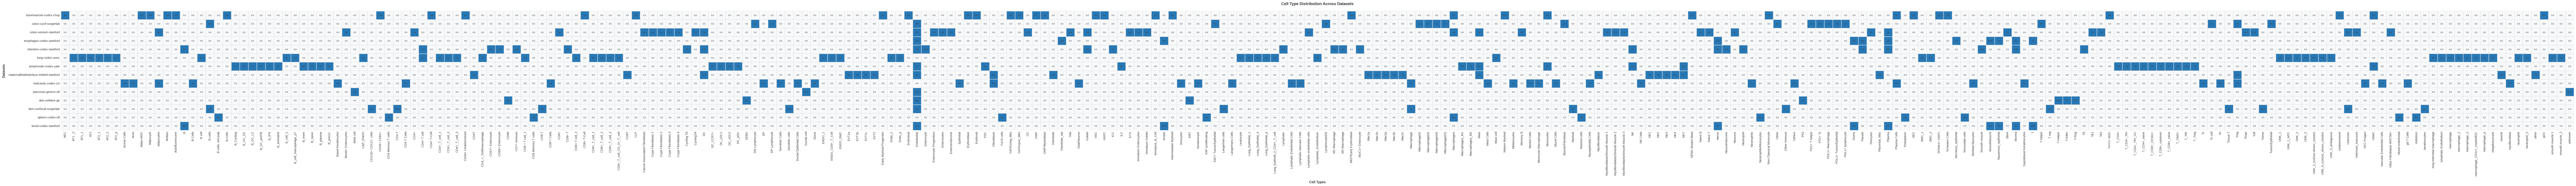

Original Cell Type                        AEC  AT1 _2  AT1_1    AT2  AT2_1  \
Tissue Type                                                                  
bonemarrow-codex-chop                    7127       0      0      0      0   
colon-cycif-sorgerlab                       0       0      0      0      0   
colon-xenium-stanford                       0       0      0      0      0   
esophagus-codex-stanford                    0       0      0      0      0   
intestine-codex-stanford                    0       0      0      0      0   
lung-codex-urmc                             0   14727  29455  97933  50215   
lymphnode-codex-yale                        0       0      0      0      0   
maternalfetalinterface-mibitof-stanford     0       0      0      0      0   
oralcavity-codex-czi                        0       0      0      0      0   
pancreas-geomx-ufl                          0       0      0      0      0   
skin-celldive-ge                            0       0      0      0      0   
skin-confocal-sorgerlab                     0       0      0      0      0   
spleen-codex-ufl                            0       0      0      0      0   
tonsil-codex-stanford                       0       0      0      0      0   

Original Cell Type                       AT2_2  AT2_p  Acinar Cells  Acini  \
Tissue Type                                                                  
bonemarrow-codex-chop                        0      0             0      0   
colon-cycif-sorgerlab                        0      0             0      0   
colon-xenium-stanford                        0      0             0      0   
esophagus-codex-stanford                     0      0             0      0   
intestine-codex-stanford                     0      0             0      0   
lung-codex-urmc                          19747  17355             0      0   
lymphnode-codex-yale                         0      0             0      0   
maternalfetalinterface-mibitof-stanford      0      0             0      0   
oralcavity-codex-czi                         0      0        173438  63090   
pancreas-geomx-ufl                           0      0             0      0   
skin-celldive-ge                             0      0             0      0   
skin-confocal-sorgerlab                      0      0             0      0   
spleen-codex-ufl                             0      0             0      0   
tonsil-codex-stanford                        0      0             0      0   

Original Cell Type                       Adipo-MSC  Adipocyte  Adipocytes  \
Tissue Type                                                                 
bonemarrow-codex-chop                         7967      23798           0   
colon-cycif-sorgerlab                            0          0           0   
colon-xenium-stanford                            0          0       19998   
esophagus-codex-stanford                         0          0           0   
intestine-codex-stanford                         0          0           0   
lung-codex-urmc                                  0          0           0   
lymphnode-codex-yale                             0          0           0   
maternalfetalinterface-mibitof-stanford          0          0           0   
oralcavity-codex-czi                             0          0        1357   
pancreas-geomx-ufl                               0          0           0   
skin-celldive-ge                                 0          0           0   
skin-confocal-sorgerlab                          0          0           0   
spleen-codex-ufl                                 0          0           0   
tonsil-codex-stanford                            0          0           0   

Original Cell Type                       Artifact  Autofluorescent      B  \
Tissue Type                                                                 
bonemarrow-codex-chop                       28818            40530      0   
colon-cycif-sorgerlab                 

In [19]:
heatmap_df_loriginal = df_all_data.groupby(['Tissue Type', 'Original Cell Type']).size().unstack(fill_value=0)
# Create a heatmap of the summary DataFrame
create_heatmap(heatmap_df_loriginal, normalize_method='percent', cell_type_level='Original Cell Type')
plt.show()
heatmap_df_loriginal

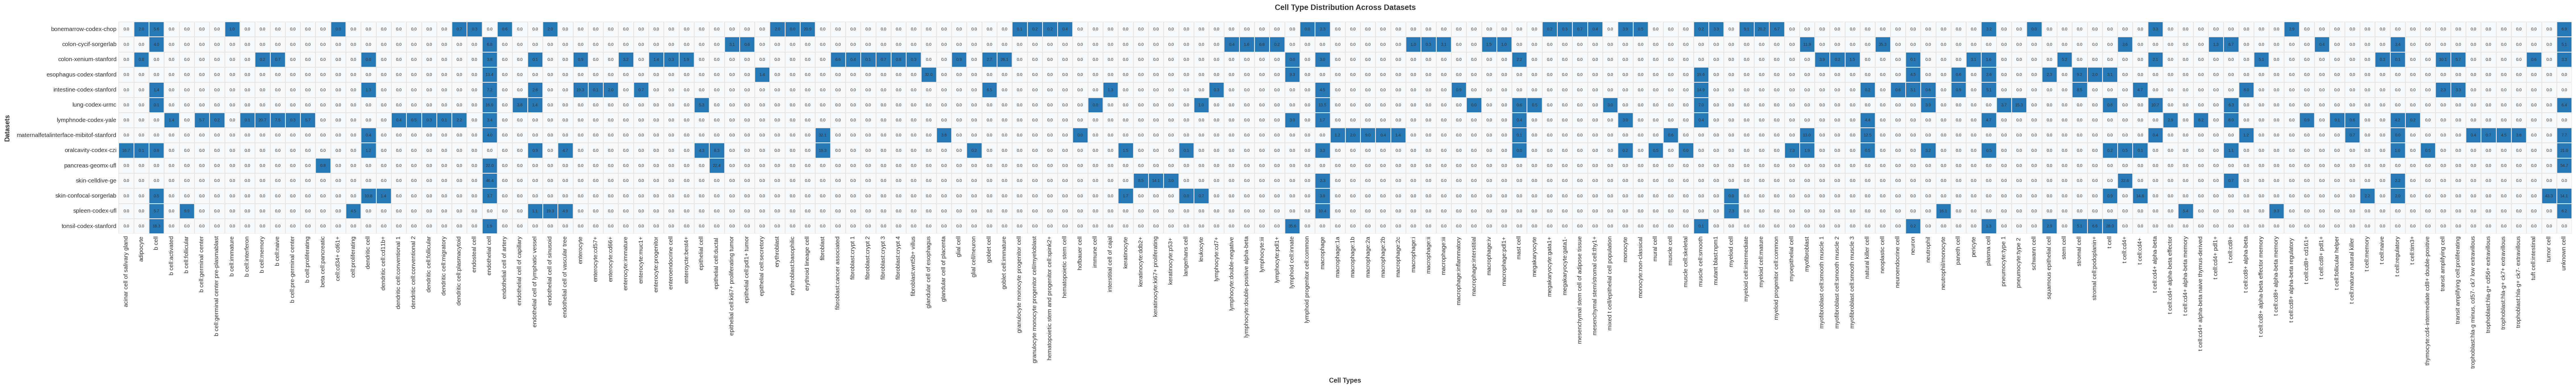

Level Three Cell Type                    acinar cell of salivary gland  \
Tissue Type                                                              
bonemarrow-codex-chop                                                0   
colon-cycif-sorgerlab                                                0   
colon-xenium-stanford                                                0   
esophagus-codex-stanford                                             0   
intestine-codex-stanford                                             0   
lung-codex-urmc                                                      0   
lymphnode-codex-yale                                                 0   
maternalfetalinterface-mibitof-stanford                              0   
oralcavity-codex-czi                                            236528   
pancreas-geomx-ufl                                                   0   
skin-celldive-ge                                                     0   
skin-confocal-sorgerlab                                              0   
spleen-codex-ufl                                                     0   
tonsil-codex-stanford                                                0   

Level Three Cell Type                    adipocyte  b cell  b cell:activated  \
Tissue Type                                                                    
bonemarrow-codex-chop                        23798   67639                 0   
colon-cycif-sorgerlab                            0  513904                 0   
colon-xenium-stanford                        19998       0                 0   
esophagus-codex-stanford                         0       0                 0   
intestine-codex-stanford                         0   35506                 0   
lung-codex-urmc                                  0    1314                 0   
lymphnode-codex-yale                             0       0            126134   
maternalfetalinterface-mibitof-stanford          0       0                 0   
oralcavity-codex-czi                          1357   13227                 0   
pancreas-geomx-ufl                               0       0                 0   
skin-celldive-ge                                 0       0                 0   
skin-confocal-sorgerlab                          0     257                 0   
spleen-codex-ufl                                 0   56246                 0   
tonsil-codex-stanford                            0   31867                 0   

Level Three Cell Type                    b cell:follicular  \
Tissue Type                                                  
bonemarrow-codex-chop                                    0   
colon-cycif-sorgerlab                                    0   
colon-xenium-stanford                                    0   
esophagus-codex-stanford                                 0   
intestine-codex-stanford                                 0   
lung-codex-urmc                                          0   
lymphnode-codex-yale                                     0   
maternalfetalinterface-mibitof-stanford                  0   
oralcavity-codex-czi                                     0   
pancreas-geomx-ufl                                       0   
skin-celldive-ge                                         0   
skin-confocal-sorgerlab                                  0   
spleen-codex-ufl                                     98430   
tonsil-codex-stanford                                    0   

Level Three Cell Type                    b cell:germinal center  \
Tissue Type                                                       
bonemarrow-codex-chop                                         0   
colon-cycif-sorgerlab                                         0   
colon-xenium-stanford                                         0   
esophagus-codex-stanford                                      0   
intestine-codex-stanford                                      0   
lung-codex-urmc                                               0   
lymph

In [ ]:
heatmap_df_l3 = df_all_data.groupby(['Tissue Type', 'Level Three Cell Type']).size().unstack(fill_value=0)
# Create a heatmap of the summary DataFrame
create_heatmap(heatmap_df_l3, normalize_method='percent', cell_type_level='Level Three Cell Type')
plt.show()
heatmap_df_l3


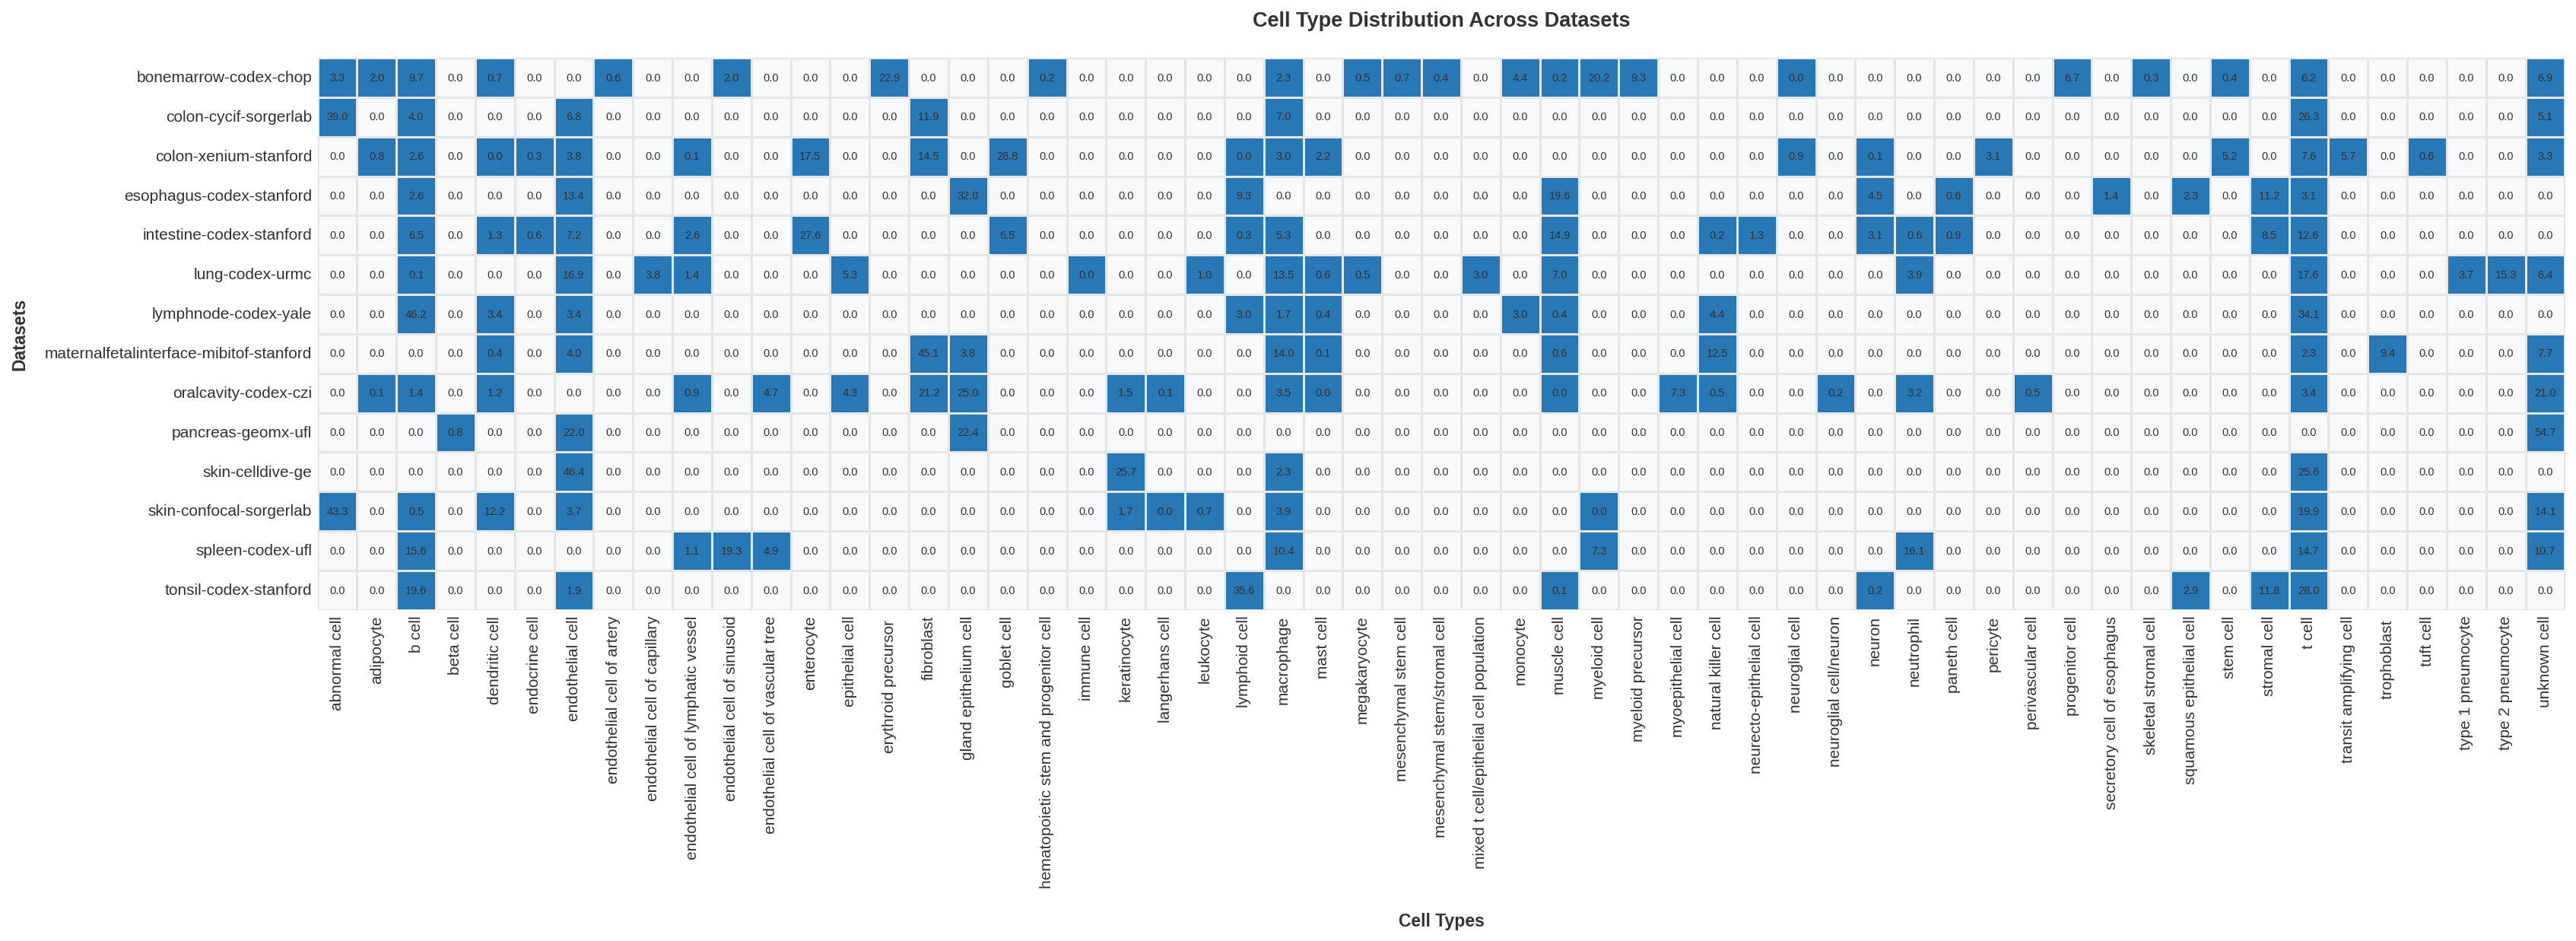

Level Two Cell Type                      abnormal cell  adipocyte   b cell  \
Tissue Type                                                                  
bonemarrow-codex-chop                            39861      23798   118366   
colon-cycif-sorgerlab                          4970579          0   513904   
colon-xenium-stanford                                0      19998    68098   
esophagus-codex-stanford                             0          0     1177   
intestine-codex-stanford                             0          0   163826   
lung-codex-urmc                                      0          0     1314   
lymphnode-codex-yale                                 0          0  4121192   
maternalfetalinterface-mibitof-stanford              0          0        0   
oralcavity-codex-czi                                 0       1357    19603   
pancreas-geomx-ufl                                   0          0        0   
skin-celldive-ge                                     0          0        0   
skin-confocal-sorgerlab                          23908          0      257   
spleen-codex-ufl                                     0          0   154676   
tonsil-codex-stanford                                0          0    34110   

Level Two Cell Type                      beta cell  dendritic cell  \
Tissue Type                                                          
bonemarrow-codex-chop                            0            8800   
colon-cycif-sorgerlab                            0               0   
colon-xenium-stanford                            0             280   
esophagus-codex-stanford                         0               0   
intestine-codex-stanford                         0           32002   
lung-codex-urmc                                  0               0   
lymphnode-codex-yale                             0          307086   
maternalfetalinterface-mibitof-stanford          0            1831   
oralcavity-codex-czi                             0           17028   
pancreas-geomx-ufl                          124066               0   
skin-celldive-ge                                 0               0   
skin-confocal-sorgerlab                          0            6736   
spleen-codex-ufl                                 0               0   
tonsil-codex-stanford                            0               0   

Level Two Cell Type                      endocrine cell  endothelial cell  \
Tissue Type                                                                 
bonemarrow-codex-chop                                 0                 0   
colon-cycif-sorgerlab                                 0            870316   
colon-xenium-stanford                              8859            100459   
esophagus-codex-stanford                              0              6181   
intestine-codex-stanford                          14970            180762   
lung-codex-urmc                                       0            204947   
lymphnode-codex-yale                                  0            303403   
maternalfetalinterface-mibitof-stanford               0             19045   
oralcavity-codex-czi                                  0                 0   
pancreas-geomx-ufl                                    0           3280557   
skin-celldive-ge                                      0             22427   
skin-confocal-sorgerlab                               0              2042   
spleen-codex-ufl                                      0                 0   
tonsil-codex-stanford                                 0              3295   

Level Two Cell Type                      endothelial cell of artery  \
Tissue Type                                                           
bonemarrow-codex-chop                                          7127   
colon-cycif-sorgerlab                                             0   
colon-xenium-stanford                                             0   
esophagus-codex-stanford                  

In [17]:
heatmap_df_l2 = df_all_data.groupby(['Tissue Type', 'Level Two Cell Type']).size().unstack(fill_value=0)
# Create a heatmap of the summary DataFrame
create_heatmap(heatmap_df_l2, normalize_method='percent', cell_type_level='Level Two Cell Type')
plt.show()
heatmap_df_l2

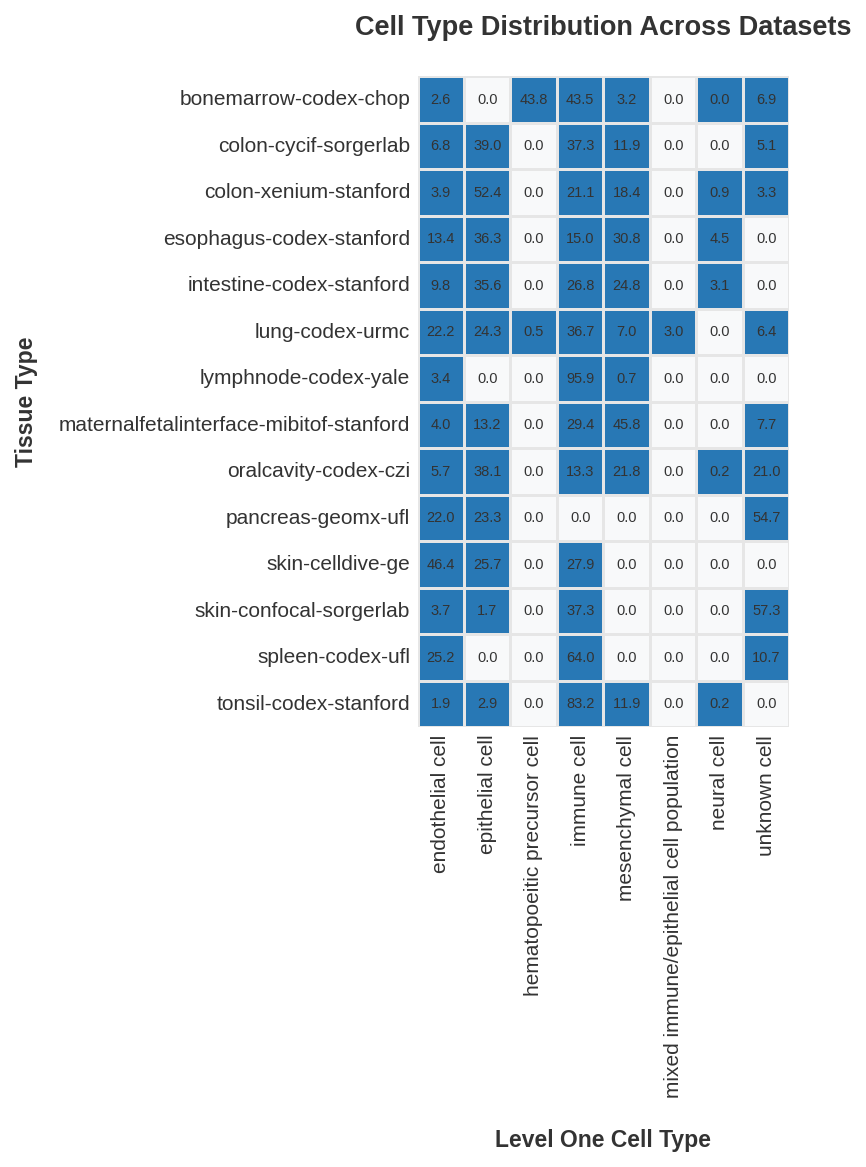

Level One Cell Type                      endothelial cell  epithelial cell  \
Tissue Type                                                                  
bonemarrow-codex-chop                               31767                0   
colon-cycif-sorgerlab                              870316          4970579   
colon-xenium-stanford                              102137          1383531   
esophagus-codex-stanford                             6181            16700   
intestine-codex-stanford                           245260           893692   
lung-codex-urmc                                    268507           294110   
lymphnode-codex-yale                               303403                0   
maternalfetalinterface-mibitof-stanford             19045            63109   
oralcavity-codex-czi                                79789           537875   
pancreas-geomx-ufl                                3280557          3463907   
skin-celldive-ge                                    22427            12407   
skin-confocal-sorgerlab                              2042              948   
spleen-codex-ufl                                   250375                0   
tonsil-codex-stanford                                3295             5013   

Level One Cell Type                      hematopoeitic precursor cell  \
Tissue Type                                                             
bonemarrow-codex-chop                                          531962   
colon-cycif-sorgerlab                                               0   
colon-xenium-stanford                                               0   
esophagus-codex-stanford                                            0   
intestine-codex-stanford                                            0   
lung-codex-urmc                                                  5595   
lymphnode-codex-yale                                                0   
maternalfetalinterface-mibitof-stanford                             0   
oralcavity-codex-czi                                                0   
pancreas-geomx-ufl                                                  0   
skin-celldive-ge                                                    0   
skin-confocal-sorgerlab                                             0   
spleen-codex-ufl                                                    0   
tonsil-codex-stanford                                               0   

Level One Cell Type                      immune cell  mesenchymal cell  \
Tissue Type                                                              
bonemarrow-codex-chop                         528183             38730   
colon-cycif-sorgerlab                        4755298           1517623   
colon-xenium-stanford                         556535            485675   
esophagus-codex-stanford                        6875             14155   
intestine-codex-stanford                      674418            621912   
lung-codex-urmc                               443414             84712   
lymphnode-codex-yale                         8556416             59026   
maternalfetalinterface-mibitof-stanford       140244            218760   
oralcavity-codex-czi                          187796            307818   
pancreas-geomx-ufl                                 0                 0   
skin-celldive-ge                               13489                 0   
skin-confocal-sorgerlab                        20589                 0   
spleen-codex-ufl                              635496                 0   
tonsil-codex-stanford                         144720             20659   

Level One Cell Type                      mixed immune/epithelial cell population  \
Tissue Type                                                                        
bonemarrow-codex-chop                                                          0   
colon-cycif-sorgerlab                                                          0   
colon-xenium-stanford                                        

In [21]:
heatmap_df_l1 = df_all_data.groupby(['Tissue Type', 'Level One Cell Type']).size().unstack(fill_value=0)
# Create a heatmap of the summary DataFrame
create_heatmap(heatmap_df_l1, normalize_method='percent', cell_type_level='Level One Cell Type')
plt.show()
heatmap_df_l1